# ST-DBSCAN Clustering of Teil Quake Tweets

This code relies on the **ST-DBSCAN** algorithm, which is a spatial-temporal clustering algorithm. It is based on the DBSCAN algorithm, but with the addition of a time dimension. We have used the following implementation [ST-DBSCAN](https://github.com/eren-ck/st_dbscan).

```bash
$ pip install st_dbscan
```

### Importing Libraries

We use **pandas** for data manipulation, **st_dbscan** for clustering and **matplotlib** for plotting.

In [1]:
import os
import time
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from st_dbscan import ST_DBSCAN
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon

%matplotlib widget

### Reading the data

We use *hdf* format to store the data since it is more efficient than csv. We use the **pandas** library to read the data.

In [2]:
# Set data directory
data_dir = os.path.realpath("../data")

# Check if file exists
if os.path.exists(os.path.join(data_dir, "tweets.h5")):
    # Read tweets from htweets5
    tweets = pd.read_hdf(os.path.join(data_dir, "tweets.h5"), "tweets")
else:
    # Convert tweets to htweets5
    # ? hdf manages large data well
    tweets = pd.read_csv(os.path.join(data_dir, "tweets.csv"))
    tweets.to_hdf(os.path.join(data_dir, "tweets.h5"), "tweets")

### Data Preprocessing

We start by removing tweets with no location information. We then remove tweets that are not in France. We then remove tweets that are not in the 48 contiguous states. We then order the tweets by time for logical processing. We remove tweets that are not in the time range of interest. Finally we'll set a new index for the data.

In [3]:
# Remove null longitude and latitude values
tweets = tweets[tweets["longitude"].notnull()]

# Constrain the area to France
tweets = tweets.loc[
    (tweets.latitude > 42.33278)
    & (tweets.latitude < 51.08917)
    & (tweets.longitude > -4.795556)
    & (tweets.longitude < 8.230556)
]

# Order tweets by date time
tweets['createdAt'] = pd.to_datetime(tweets['createdAt'])
tweets.sort_values(by="createdAt", inplace=True)

# Remove columns that are not needed
try:
    tweets.drop(columns=['tweetId', 'mention', 'start', 'end', 'altitude', 'osm', 'geonames'], inplace=True)
except:
    pass

# Set id as index
tweets["id"] = range(1, len(tweets) + 1)
tweets.set_index('id', inplace=True, verify_integrity=False)

### Reprojecting the data

Since we will be focusing on France, we will reproject the data to the Lambert Conformal Conic projection. This projection is used in France to represent the country on a flat map. We will use the **geopandas** library to do this.

In [4]:
# Convert tweets to geodataframe
tweets = gpd.GeoDataFrame(tweets, geometry=gpd.points_from_xy(tweets.longitude, tweets.latitude), crs="EPSG:4326")

# Convert WGS84 to lambert93
tweets = tweets.to_crs("EPSG:2154")

# Calculate projected coordinates
tweets['x_m'] = tweets.geometry.x.round(3)
tweets['y_m'] = tweets.geometry.y.round(3)

# Reorder columns
tweets = tweets[['text', 'entity', 'wikidata', 'x_m', 'y_m', 'createdAt', 'geometry']]

In [5]:
tweets.head()

,text,entity,wikidata,x_m,y_m,createdAt,geometry
id,,,,,,,
1,il y a 23 min #seisme 2.0 a frappé Arbaz (Sion...,Arbaz,Q68113,1037421.834,6583455.288,2019-11-11 09:23:24+00:00,POINT (1037421.834 6583455.288)
2,Tremblement de terre à Lyon en ce moment !!!,Lyon,Q456,843121.942,6519367.222,2019-11-11 10:53:46+00:00,POINT (843121.942 6519367.222)
3,#Séisme ressenti à #Lyon à l'instant,Lyon,Q456,843121.942,6519367.222,2019-11-11 10:53:56+00:00,POINT (843121.942 6519367.222)
4,Tremblement de terre en Ardèche à l'instant,Ardèche (département),Q3148,812290.663,6397402.763,2019-11-11 10:54:09+00:00,POINT (812290.663 6397402.763)
5,Wait ! Y’a des tremblements de terre en France...,France,Q142,624015.535,6656012.010,2019-11-11 10:54:18+00:00,POINT (624015.535 6656012.010)


### Clustering using ST-DBSCAN

We'll start by normalizing the data. We'll then use the ST-DBSCAN algorithm to cluster the data. We'll use the **ST_DBSCAN** library to do this.

In [6]:
# Normalize coordinates
# ! Test whether normalization speeds up the algorithm
tweets['x_m_norm'] = (tweets['x_m'] - tweets['x_m'].min()) / (tweets['x_m'].max() - tweets['x_m'].min())
tweets['y_m_norm'] = (tweets['y_m'] - tweets['y_m'].min()) / (tweets['y_m'].max() - tweets['y_m'].min())

# Convert datetime to timestamp
tweets['ts'] = tweets['createdAt'].values.astype(np.int64) // 10 ** 9

# Input to ST-DBSCAN
data = tweets.loc[:, ['ts','x_m_norm','y_m_norm']].values

# We'll be used for plotting (we can't plot normalized coordinates)
COORDS = tweets.loc[:, ['x_m','y_m']].values

In [7]:
# ST-DBSCAN Clustering
# Parameters
eps1 = 0.1 # Distance threshold
eps2 = 60*10 # Time threshold
min_samples = 22 # Minimum number of points in a cluster

start = time.time()
st_dbscan = ST_DBSCAN(eps1 = eps1, eps2 = eps2, min_samples = min_samples).fit(data)
end = time.time()

print("Time taken: ", end - start)
print("Number of clusters: {}".format(len(set(st_dbscan.labels))))

# Add cluster column to tweets
tweets['cluster'] = st_dbscan.labels

Time taken:  1.8098196983337402
Number of clusters: 5


### Create convex hulls for each cluster

In order to assess the extent of the quake, we'll create a convex hull for each cluster. We'll use the **scipy.spatial** library to do this.

In [8]:
# Create a hulls geodataframe
hulls = gpd.GeoDataFrame(columns=['cluster', 'num_tweets', 'area_km2', 'geometry'])

for cluster in set(st_dbscan.labels):
    if cluster != -1:
        # Get the coordinates of the points in the cluster
        points = COORDS[st_dbscan.labels == cluster]
        # Create a convex hull
        try:
            hull = ConvexHull(points)
        except:
            continue
        # Append the cluster and hull to the geodataframe using concat instead of append
        hulls = pd.concat([hulls, gpd.GeoDataFrame({
            'cluster': [cluster],
            'num_tweets': [len(points)],
            'geometry': [Polygon(points[hull.vertices])]
        })], ignore_index=True)

hulls.set_crs(epsg=2154, inplace=True)

# Calculate the area of the hulls
hulls['area_km2'] = round(hulls['geometry'].area / 1_000_000, 2)

In [9]:
hulls.head()

,cluster,num_tweets,area_km2,geometry
0,0,3644,57095.45,"POLYGON ((759494.449 6278654.288, 894593.377 6..."
1,2,67,11161.97,"POLYGON ((838057.960 6360621.723, 914078.319 6..."
2,3,575,24820.61,"POLYGON ((914078.319 6457877.621, 843121.942 6..."


### Plot the clusters

We'll use the **matplotlib** library to plot the clusters. As a base map, we'll have a map of France. We'll use the **geopandas** library to do this.

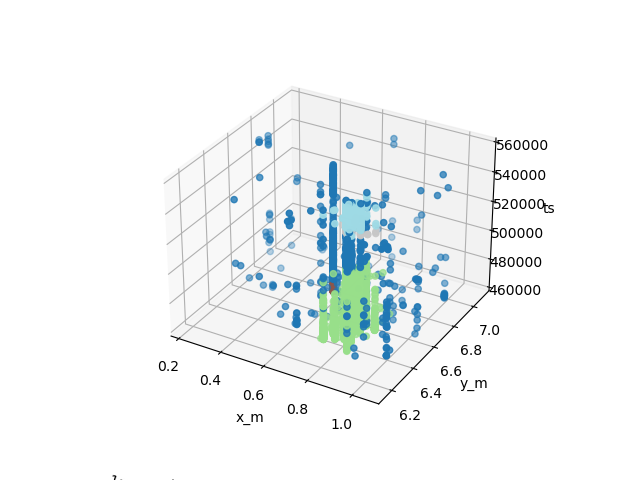

In [10]:
# Plot hulls in 3D
ax = plt.axes(projection='3d')
ax.scatter3D(tweets['x_m'], tweets['y_m'], tweets['ts'], c=tweets['cluster'], cmap='tab20')
ax.set_xlabel('x_m')
ax.set_ylabel('y_m')
ax.set_zlabel('ts')
plt.show()

In [11]:
# Read France geojson
france = gpd.read_file(filename='../data/france.geojson')
france = france.to_crs("EPSG:2154")

Cluster -1: 731 tweets
Cluster 0: 3644 tweets
Cluster 2: 67 tweets
Cluster 3: 575 tweets


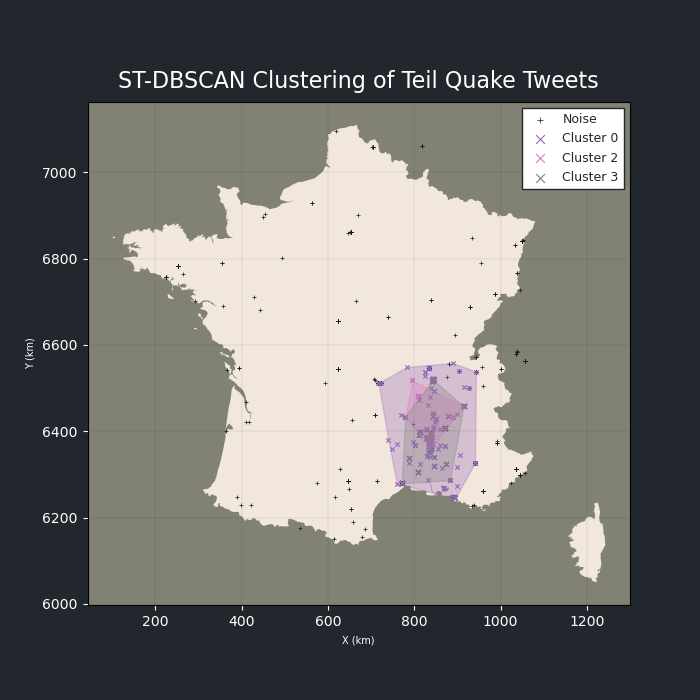

In [12]:
# Plot base map
base = france.plot(color='#F2E7DC', figsize=(7, 7), linewidth=0)
base.set_facecolor('#818274')
base.get_figure().patch.set_facecolor('#22272e')

# Plot tweets with color based on cluster
for cluster in tweets.cluster.unique():
    # Number of tweets in cluster
    num_tweets = len(tweets[tweets.cluster == cluster])
    # Check whether cluster id exists in hulls
    if cluster in hulls.cluster.values or cluster == -1:
        print("Cluster {}: {} tweets".format(cluster, num_tweets))
        tweets[tweets.cluster == cluster].plot(
            ax=base,
            markersize=6 if cluster == -1 else 10,
            label='Noise' if cluster == -1 else 'Cluster {}'.format(cluster),
            # alpha=0.4 if cluster == -1 else 1,
            marker='x' if cluster != -1 else '+',
            color='#161819' if cluster == -1 else 'C{}'.format(cluster + 4),
            linewidth=0.5 if cluster == -1 else 0.8,
        )
    
for cluster in hulls.cluster:
    hulls[hulls.cluster == cluster].plot(
        ax=base,
        alpha=0.3,
        color='C{}'.format(cluster + 4),
        edgecolor='C{}'.format(cluster + 4),
        linewidth=1
    )

# Set title
base.set_title("ST-DBSCAN Clustering of Teil Quake Tweets", fontsize=16, weight='medium', color='white', pad=10)

# Set legend
base.legend(loc='best', fontsize=9, labelcolor='#22272e', markerscale=2, facecolor='white', title_fontsize=14, fancybox=False, framealpha=1, edgecolor='#22272e')
# bbox_to_anchor=(1.23, 1.01

# Add grid
base.grid(color='#161819', linestyle='-', linewidth=0.2, alpha=0.3)

# Change tick labels
m2km = lambda x, _: f'{x/1000:g}'
base.xaxis.set_major_formatter(m2km)
base.yaxis.set_major_formatter(m2km)

# Set axis labels
base.set_xlabel("X (km)", fontsize=7, labelpad=5, color='white')
base.set_ylabel("Y (km)", fontsize=7, labelpad=5, color='white')

# Set axis ticks color
base.tick_params(axis='x', colors='white')
base.tick_params(axis='y', colors='white')

In [13]:
# Save figure
base.get_figure().savefig('../images/dbscan.png', dpi=300, bbox_inches='tight', facecolor=base.get_figure().get_facecolor(), edgecolor='none')

In [ ]:
# Export tweets to geojson
tweets.to_file('../data/tweets_clustered.geojson', driver='GeoJSON')